## Crypto Prediction with LSTM: BitCoin (BTC) 

## 30 Day Lookback

- This notebook attempts to use TensorFlow Keras LSTM to predict movement in Crypto prices
- Data is pulled from the CoinApi, so it can be refreshed at any point and retrained
- 2 optimizations were used and an overall R2 score of .92 was attained
- This update uses a 30 day lookback window, in order to assess whether the greater lookback time has an impact on training and prediction.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import tensorflow as tf
from copy import deepcopy as dc
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.optimizers import Adam
import datetime as dt


from api_keys import coinapi_key

2023-09-18 15:55:01.505617: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Pull BTC data from coinapi

url = 'https://rest.coinapi.io/v1/ohlcv/BITSTAMP_SPOT_BTC_USD/history?period_id=1DAY&limit=20000'
headers = {'X-CoinAPI-Key' : coinapi_key}
response = requests.get(url, headers=headers)
 
if response.status_code == 200:
    json_data = response.json()
    print(json_data)
else:
    print(f"Error: {response.status_code}")

[{'time_period_start': '2023-09-18T00:00:00.0000000Z', 'time_period_end': '2023-09-19T00:00:00.0000000Z', 'time_open': '2023-09-18T00:00:10.5790000Z', 'time_close': '2023-09-18T19:56:04.4820000Z', 'price_open': 26533, 'price_high': 27421, 'price_low': 26382, 'price_close': 26871, 'volume_traded': 1732.66085396, 'trades_count': 11582}, {'time_period_start': '2023-09-17T00:00:00.0000000Z', 'time_period_end': '2023-09-18T00:00:00.0000000Z', 'time_open': '2023-09-17T00:00:28.1100000Z', 'time_close': '2023-09-17T23:59:20.7440000Z', 'price_open': 26571, 'price_high': 26618, 'price_low': 26414, 'price_close': 26535, 'volume_traded': 529.80823767, 'trades_count': 7247}, {'time_period_start': '2023-09-16T00:00:00.0000000Z', 'time_period_end': '2023-09-17T00:00:00.0000000Z', 'time_open': '2023-09-16T00:00:06.6310000Z', 'time_close': '2023-09-16T23:59:36.1270000Z', 'price_open': 26609, 'price_high': 26767, 'price_low': 26459, 'price_close': 26571, 'volume_traded': 602.34030269, 'trades_count': 76

In [3]:
#Convert json to pandas df
df = pd.DataFrame(json_data)

df.head()

,time_period_start,time_period_end,time_open,time_close,price_open,price_high,price_low,price_close,volume_traded,trades_count
0,2023-09-18T00:00:00.0000000Z,2023-09-19T00:00:00.0000000Z,2023-09-18T00:00:10.5790000Z,2023-09-18T19:56:04.4820000Z,26533.0,27421.0,26382.0,26871.0,1732.660854,11582
1,2023-09-17T00:00:00.0000000Z,2023-09-18T00:00:00.0000000Z,2023-09-17T00:00:28.1100000Z,2023-09-17T23:59:20.7440000Z,26571.0,26618.0,26414.0,26535.0,529.808238,7247
2,2023-09-16T00:00:00.0000000Z,2023-09-17T00:00:00.0000000Z,2023-09-16T00:00:06.6310000Z,2023-09-16T23:59:36.1270000Z,26609.0,26767.0,26459.0,26571.0,602.340303,7658
3,2023-09-15T00:00:00.0000000Z,2023-09-16T00:00:00.0000000Z,2023-09-15T00:00:32.9490000Z,2023-09-15T23:59:45.8940000Z,26529.0,26878.0,26228.0,26607.0,1379.105636,11902
4,2023-09-14T00:00:00.0000000Z,2023-09-15T00:00:00.0000000Z,2023-09-14T00:00:15.5360000Z,2023-09-14T23:59:56.7440000Z,26229.0,26849.0,26143.0,26529.0,2067.195177,14687


In [4]:
#reduce df to x and y columns
data = df[["time_period_start", "price_close"]]

#rename columns
data = data.rename(columns={"time_period_start":"Date","price_close":"Close"})

#convert date to dt, refomat to yyyymmdd
data['Date'] = pd.to_datetime(data['Date']).dt.date

#json return began with most recent date, reversed for plotting/analysis
data = data.reindex(index=data.index[::-1])

#set date as index
data.set_index('Date', inplace=True)

data.head()

,Close
Date,
2011-09-13,5.97
2011-09-14,5.53
2011-09-15,5.13
2011-09-16,4.85
2011-09-17,4.87


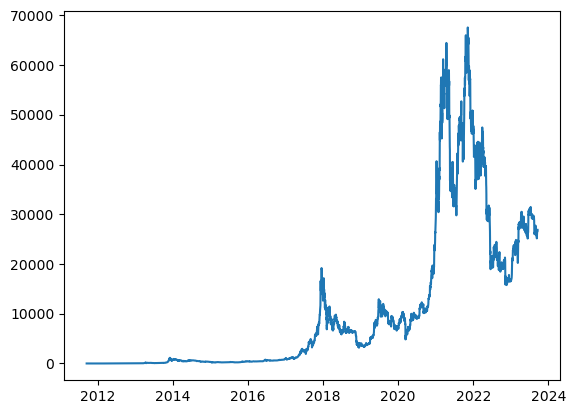

In [5]:
#plot historical amzn price
plt.plot(data)

In [6]:
# Set parameters for model

lookback = 30

split_1 = .8
split_2 = .9

In [7]:
# build lookback for lstm training
def prepare_dataframe_for_lstm(data, n_steps):
    data = dc(data)
    
    for i in range(1, n_steps+1):
        data[f'Close(t-{i})'] = data['Close'].shift(i)
        
    data.dropna(inplace=True)
    
    return data

shifted_df = prepare_dataframe_for_lstm(data, lookback)

# name date column from new index (since start date is absorbed into first x windows)
dates = shifted_df.index

#convert from df to numpy array
shifted_df_as_np = shifted_df.to_numpy()

#Scale Data
log_transformed_data = np.log(shifted_df_as_np)



# Split key from features
X1 = log_transformed_data[:, 1:]
y1 = log_transformed_data[:, 0]

#flip order of windows (needs to start with most recent)

X1 = dc(np.flip(X1, axis=1))
X1


X1.shape, y1.shape, dates.shape


((4206, 30), (4206,), (4206,))

In [8]:
#Calculate split points based on previously defined variables
train_split = int(len(X1) * split_1)
test_split = int(len(X1) * split_2)

#Define spilt points for train/val/test
dates_train1, X_train1, y_train1 = dates[:train_split],X1[:train_split], y1[:train_split]
dates_val1, X_val1, y_val1 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test1, X_test1, y_test1 = dates[test_split:], X1[test_split:], y1[test_split:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((3364, 30), (3364,), (421, 30), (421,), (421, 30), (421,))

In [95]:
#Build, compile, fit LSTM model

model = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=100)

Epoch 1/100
106/106 [==============================] - 6s 28ms/step - loss: 12.3580 - mean_absolute_error: 2.2057 - val_loss: 0.0402 - val_mean_absolute_error: 0.1683
Epoch 2/100
106/106 [==============================] - 3s 28ms/step - loss: 0.0081 - mean_absolute_error: 0.0626 - val_loss: 0.0113 - val_mean_absolute_error: 0.0855
Epoch 3/100
106/106 [==============================] - 3s 25ms/step - loss: 0.0068 - mean_absolute_error: 0.0560 - val_loss: 0.0097 - val_mean_absolute_error: 0.0762
Epoch 4/100
106/106 [==============================] - 2s 16ms/step - loss: 0.0071 - mean_absolute_error: 0.0595 - val_loss: 0.0075 - val_mean_absolute_error: 0.0697
Epoch 5/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0061 - mean_absolute_error: 0.0539 - val_loss: 0.0060 - val_mean_absolute_error: 0.0607
Epoch 6/100
106/106 [==============================] - 2s 21ms/step - loss: 0.0057 - mean_absolute_error: 0.0518 - val_loss: 0.0184 - val_mean_absolute_error: 0.1214
Epo

106/106 [==============================] - 2s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0418 - val_loss: 0.0068 - val_mean_absolute_error: 0.0732
Epoch 51/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0035 - mean_absolute_error: 0.0399 - val_loss: 0.0144 - val_mean_absolute_error: 0.1137
Epoch 52/100
106/106 [==============================] - 2s 17ms/step - loss: 0.0033 - mean_absolute_error: 0.0386 - val_loss: 0.0225 - val_mean_absolute_error: 0.1446
Epoch 53/100
106/106 [==============================] - 2s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0388 - val_loss: 0.0019 - val_mean_absolute_error: 0.0351
Epoch 54/100
106/106 [==============================] - 2s 15ms/step - loss: 0.0035 - mean_absolute_error: 0.0406 - val_loss: 0.0045 - val_mean_absolute_error: 0.0568
Epoch 55/100
106/106 [==============================] - 2s 16ms/step - loss: 0.0038 - mean_absolute_error: 0.0440 - val_loss: 0.0247 - val_mean_absolute_error: 0.1520
Epoch 56/10

106/106 [==============================] - 2s 21ms/step - loss: 0.0030 - mean_absolute_error: 0.0363 - val_loss: 0.0049 - val_mean_absolute_error: 0.0622
Epoch 100/100
106/106 [==============================] - 2s 16ms/step - loss: 0.0031 - mean_absolute_error: 0.0372 - val_loss: 0.0101 - val_mean_absolute_error: 0.0938


106/106 [==============================] - 1s 5ms/step


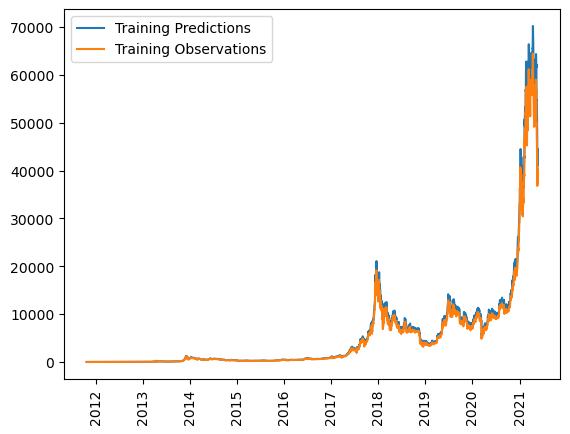

In [96]:
# Check training predictions (use np.exp to transform scaled data back to original scale)

train_predictions = model.predict(X_train1).flatten()

plt.plot(dates_train1, np.exp(train_predictions))
plt.plot(dates_train1, np.exp(y_train1))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [97]:
# Check scores for val period
score = model.evaluate(X_val1, y_val1, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.010130210779607296
Val MAE: 0.09382062405347824


14/14 [==============================] - 0s 7ms/step


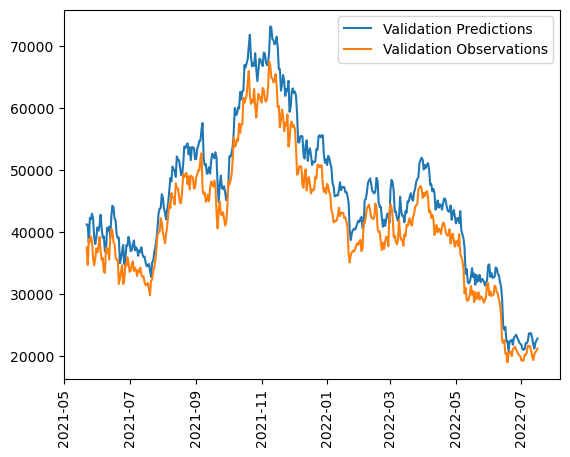

In [98]:
# graphed performance of val data in model
val_predictions = model.predict(X_val1).flatten()

plt.plot(dates_val1, np.exp(val_predictions))
plt.plot(dates_val1, np.exp(y_val1))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [99]:
score = model.evaluate(X_test1, y_test1, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.008918484672904015
Test MAE: 0.09078440070152283


14/14 [==============================] - 0s 7ms/step


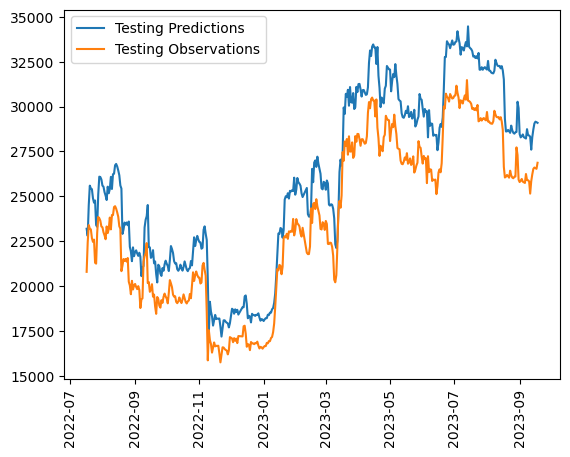

In [100]:
#check model against test data
test_predictions = model.predict(X_test1).flatten()

plt.plot(dates_test1, np.exp(test_predictions))
plt.plot(dates_test1, np.exp(y_test1))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [101]:
# Check r2 score
print('R2 Score: ', r2_score(y_test1, test_predictions))

R2 Score:  0.764257996294627


## Optimization of the Model

- Adjust the initial data used, limited to the last 50% of the data
- Focus more on recent trends for learning
- Increase Epochs
- Slow learning rate

In [102]:
# Split is changed to begin at 50% of the dataset and continue to the end.
split_1 = .5
split_2 = .89
split_3 = .95


initial_split = int(len(X1) * split_1)
train_split = int(len(X1) * split_2)
test_split = int(len(X1) * split_3)

In [103]:
#change timeframe

dates_train2, X_train2, y_train2 = dates[initial_split:train_split],X1[initial_split:train_split], y1[initial_split:train_split]
dates_val2, X_val2, y_val2 = dates[train_split:test_split], X1[train_split:test_split], y1[train_split:test_split]
dates_test2, X_test2, y_test2 = dates[test_split:], X1[test_split:], y1[test_split:]
dates_train2.shape, X_train2.shape, y_train2.shape, \
dates_val2.shape, X_val2.shape, y_val2.shape, \
dates_test2.shape, X_test2.shape, y_test2.shape

((1640,),
 (1640, 30),
 (1640,),
 (252,),
 (252, 30),
 (252,),
 (211,),
 (211, 30),
 (211,))

In [104]:
# Build, compile and fit the new model- increased epochs, smaller learning rate
model2 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model2.compile(loss='mse',
              optimizer=Adam(learning_rate=0.0001),
              metrics=['mean_absolute_error'])

model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=300)

Epoch 1/300
106/106 [==============================] - 5s 23ms/step - loss: 43.1564 - mean_absolute_error: 6.0781 - val_loss: 81.8373 - val_mean_absolute_error: 9.0418
Epoch 2/300
106/106 [==============================] - 2s 19ms/step - loss: 21.6740 - mean_absolute_error: 4.0713 - val_loss: 40.4772 - val_mean_absolute_error: 6.3553
Epoch 3/300
106/106 [==============================] - 2s 17ms/step - loss: 5.5465 - mean_absolute_error: 1.7356 - val_loss: 12.1878 - val_mean_absolute_error: 3.4787
Epoch 4/300
106/106 [==============================] - 2s 17ms/step - loss: 0.7712 - mean_absolute_error: 0.5053 - val_loss: 3.6625 - val_mean_absolute_error: 1.8915
Epoch 5/300
106/106 [==============================] - 2s 18ms/step - loss: 0.1679 - mean_absolute_error: 0.1873 - val_loss: 1.7889 - val_mean_absolute_error: 1.3059
Epoch 6/300
106/106 [==============================] - 2s 18ms/step - loss: 0.0882 - mean_absolute_error: 0.1350 - val_loss: 0.9783 - val_mean_absolute_error: 0.9478

106/106 [==============================] - 2s 17ms/step - loss: 0.0042 - mean_absolute_error: 0.0426 - val_loss: 0.0042 - val_mean_absolute_error: 0.0499
Epoch 51/300
106/106 [==============================] - 2s 19ms/step - loss: 0.0042 - mean_absolute_error: 0.0423 - val_loss: 0.0042 - val_mean_absolute_error: 0.0508
Epoch 52/300
106/106 [==============================] - 2s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0419 - val_loss: 0.0071 - val_mean_absolute_error: 0.0688
Epoch 53/300
106/106 [==============================] - 2s 20ms/step - loss: 0.0041 - mean_absolute_error: 0.0426 - val_loss: 0.0042 - val_mean_absolute_error: 0.0510
Epoch 54/300
106/106 [==============================] - 2s 19ms/step - loss: 0.0041 - mean_absolute_error: 0.0422 - val_loss: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 55/300
106/106 [==============================] - 2s 18ms/step - loss: 0.0041 - mean_absolute_error: 0.0425 - val_loss: 0.0044 - val_mean_absolute_error: 0.0521
Epoch 56/30

106/106 [==============================] - 2s 15ms/step - loss: 0.0031 - mean_absolute_error: 0.0355 - val_loss: 0.0035 - val_mean_absolute_error: 0.0463
Epoch 100/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0033 - mean_absolute_error: 0.0382 - val_loss: 0.0031 - val_mean_absolute_error: 0.0429
Epoch 101/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0034 - mean_absolute_error: 0.0393 - val_loss: 0.0021 - val_mean_absolute_error: 0.0357
Epoch 102/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0031 - mean_absolute_error: 0.0352 - val_loss: 0.0022 - val_mean_absolute_error: 0.0362
Epoch 103/300
106/106 [==============================] - 2s 16ms/step - loss: 0.0031 - mean_absolute_error: 0.0359 - val_loss: 0.0025 - val_mean_absolute_error: 0.0381
Epoch 104/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0030 - mean_absolute_error: 0.0354 - val_loss: 0.0029 - val_mean_absolute_error: 0.0411
Epoch 

Epoch 148/300
106/106 [==============================] - 2s 16ms/step - loss: 0.0029 - mean_absolute_error: 0.0349 - val_loss: 0.0021 - val_mean_absolute_error: 0.0346
Epoch 149/300
106/106 [==============================] - 2s 16ms/step - loss: 0.0030 - mean_absolute_error: 0.0362 - val_loss: 0.0022 - val_mean_absolute_error: 0.0361
Epoch 150/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0032 - mean_absolute_error: 0.0376 - val_loss: 0.0039 - val_mean_absolute_error: 0.0509
Epoch 151/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0343 - val_loss: 0.0018 - val_mean_absolute_error: 0.0322
Epoch 152/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0338 - val_loss: 0.0026 - val_mean_absolute_error: 0.0397
Epoch 153/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0332 - val_loss: 0.0029 - val_mean_absolute_error:

Epoch 197/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0330 - val_loss: 0.0016 - val_mean_absolute_error: 0.0303
Epoch 198/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0329 - val_loss: 0.0016 - val_mean_absolute_error: 0.0305
Epoch 199/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0029 - mean_absolute_error: 0.0352 - val_loss: 0.0017 - val_mean_absolute_error: 0.0304
Epoch 200/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0328 - val_loss: 0.0020 - val_mean_absolute_error: 0.0343
Epoch 201/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0327 - val_loss: 0.0017 - val_mean_absolute_error: 0.0307
Epoch 202/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0326 - val_loss: 0.0017 - val_mean_absolute_error:

Epoch 246/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0029 - mean_absolute_error: 0.0364 - val_loss: 0.0019 - val_mean_absolute_error: 0.0334
Epoch 247/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0326 - val_loss: 0.0017 - val_mean_absolute_error: 0.0322
Epoch 248/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0351 - val_loss: 0.0015 - val_mean_absolute_error: 0.0295
Epoch 249/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0340 - val_loss: 0.0016 - val_mean_absolute_error: 0.0302
Epoch 250/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0336 - val_loss: 0.0035 - val_mean_absolute_error: 0.0483
Epoch 251/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0332 - val_loss: 0.0019 - val_mean_absolute_error:

Epoch 295/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0327 - val_loss: 0.0019 - val_mean_absolute_error: 0.0324
Epoch 296/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0027 - mean_absolute_error: 0.0338 - val_loss: 0.0015 - val_mean_absolute_error: 0.0293
Epoch 297/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0323 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309
Epoch 298/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0331 - val_loss: 0.0018 - val_mean_absolute_error: 0.0323
Epoch 299/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0028 - mean_absolute_error: 0.0352 - val_loss: 0.0021 - val_mean_absolute_error: 0.0369
Epoch 300/300
106/106 [==============================] - 2s 15ms/step - loss: 0.0026 - mean_absolute_error: 0.0322 - val_loss: 0.0017 - val_mean_absolute_error:

52/52 [==============================] - 1s 5ms/step


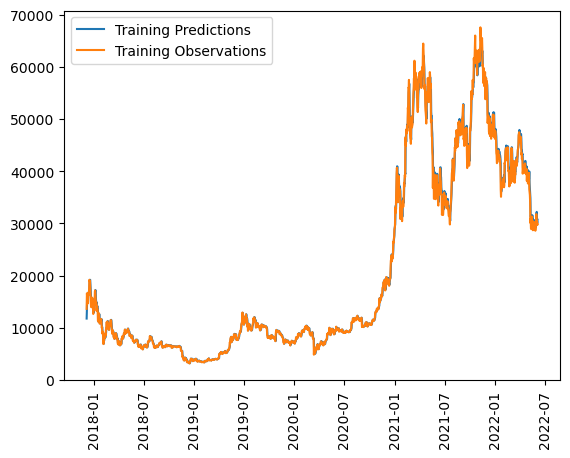

In [105]:
#Second model observations
train_predictions2 = model2.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions2))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [106]:
score = model2.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0012569122482091188
Val MAE: 0.023974118754267693


8/8 [==============================] - 0s 6ms/step


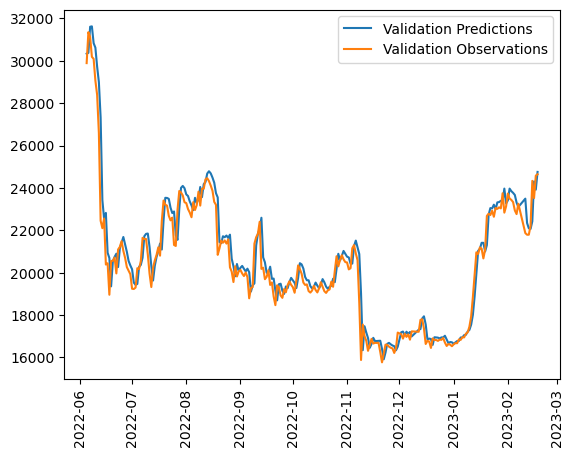

In [107]:
#Second model observations
val_predictions2 = model2.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions2))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [108]:
#MSAE Score for second model
score = model2.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.000743568642064929
Test MAE: 0.021723652258515358


In [109]:
# R2 score for second model
y_pred = model2.predict(X_test2)
print('R2 Score: ', r2_score(y_test2, y_pred))

7/7 [==============================] - 0s 6ms/step
R2 Score:  0.9003488710100125


7/7 [==============================] - 0s 6ms/step


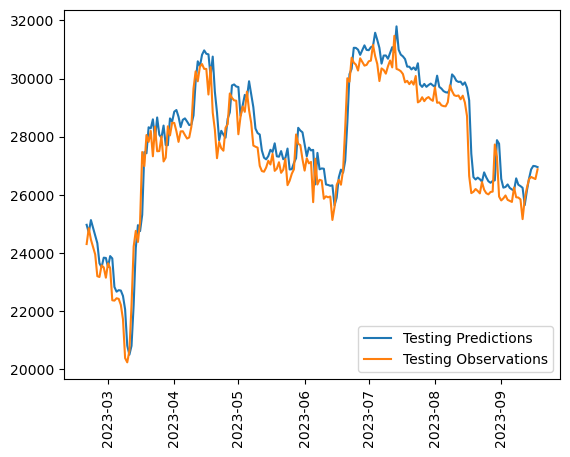

In [110]:
#Second model observations
test_predictions2 = model2.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions2))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [121]:
# Second optimization. Increased neural density, epochs
model3 = Sequential([layers.Input((lookback, 1)),
                    layers.LSTM(64, return_sequences=True),
                    layers.LSTM(32, return_sequences=False),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model3.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model3.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300)

Epoch 1/300
52/52 [==============================] - 6s 48ms/step - loss: 35.3647 - mean_absolute_error: 5.4390 - val_loss: 3.1784 - val_mean_absolute_error: 1.7776
Epoch 2/300
52/52 [==============================] - 2s 31ms/step - loss: 0.9702 - mean_absolute_error: 0.8444 - val_loss: 0.1263 - val_mean_absolute_error: 0.3283
Epoch 3/300
52/52 [==============================] - 2s 32ms/step - loss: 0.7498 - mean_absolute_error: 0.7590 - val_loss: 0.1598 - val_mean_absolute_error: 0.3759
Epoch 4/300
52/52 [==============================] - 2s 31ms/step - loss: 0.7474 - mean_absolute_error: 0.7648 - val_loss: 0.1643 - val_mean_absolute_error: 0.3818
Epoch 5/300
52/52 [==============================] - 2s 31ms/step - loss: 0.7487 - mean_absolute_error: 0.7624 - val_loss: 0.1930 - val_mean_absolute_error: 0.4177
Epoch 6/300
52/52 [==============================] - 2s 31ms/step - loss: 0.7485 - mean_absolute_error: 0.7563 - val_loss: 0.1408 - val_mean_absolute_error: 0.3497
Epoch 7/300
52/

Epoch 51/300
52/52 [==============================] - 2s 42ms/step - loss: 0.0082 - mean_absolute_error: 0.0705 - val_loss: 0.0031 - val_mean_absolute_error: 0.0409
Epoch 52/300
52/52 [==============================] - 2s 35ms/step - loss: 0.0050 - mean_absolute_error: 0.0546 - val_loss: 0.0036 - val_mean_absolute_error: 0.0467
Epoch 53/300
52/52 [==============================] - 2s 31ms/step - loss: 0.0048 - mean_absolute_error: 0.0530 - val_loss: 0.0029 - val_mean_absolute_error: 0.0372
Epoch 54/300
52/52 [==============================] - 2s 36ms/step - loss: 0.0055 - mean_absolute_error: 0.0570 - val_loss: 0.0079 - val_mean_absolute_error: 0.0745
Epoch 55/300
52/52 [==============================] - 2s 34ms/step - loss: 0.0049 - mean_absolute_error: 0.0545 - val_loss: 0.0135 - val_mean_absolute_error: 0.1084
Epoch 56/300
52/52 [==============================] - 2s 30ms/step - loss: 0.0062 - mean_absolute_error: 0.0606 - val_loss: 0.0028 - val_mean_absolute_error: 0.0361
Epoch 57/3

Epoch 101/300
52/52 [==============================] - 2s 45ms/step - loss: 0.0039 - mean_absolute_error: 0.0489 - val_loss: 0.0024 - val_mean_absolute_error: 0.0359
Epoch 102/300
52/52 [==============================] - 2s 44ms/step - loss: 0.0034 - mean_absolute_error: 0.0442 - val_loss: 0.0018 - val_mean_absolute_error: 0.0285
Epoch 103/300
52/52 [==============================] - 2s 43ms/step - loss: 0.0030 - mean_absolute_error: 0.0413 - val_loss: 0.0025 - val_mean_absolute_error: 0.0367
Epoch 104/300
52/52 [==============================] - 2s 34ms/step - loss: 0.0028 - mean_absolute_error: 0.0391 - val_loss: 0.0056 - val_mean_absolute_error: 0.0639
Epoch 105/300
52/52 [==============================] - 2s 35ms/step - loss: 0.0038 - mean_absolute_error: 0.0482 - val_loss: 0.0042 - val_mean_absolute_error: 0.0566
Epoch 106/300
52/52 [==============================] - 2s 36ms/step - loss: 0.0033 - mean_absolute_error: 0.0433 - val_loss: 0.0020 - val_mean_absolute_error: 0.0337
Epoc

52/52 [==============================] - 2s 37ms/step - loss: 0.0029 - mean_absolute_error: 0.0411 - val_loss: 0.0017 - val_mean_absolute_error: 0.0302
Epoch 151/300
52/52 [==============================] - 2s 35ms/step - loss: 0.0023 - mean_absolute_error: 0.0351 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284
Epoch 152/300
52/52 [==============================] - 2s 37ms/step - loss: 0.0025 - mean_absolute_error: 0.0370 - val_loss: 0.0016 - val_mean_absolute_error: 0.0288
Epoch 153/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0026 - mean_absolute_error: 0.0383 - val_loss: 0.0019 - val_mean_absolute_error: 0.0323
Epoch 154/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0052 - mean_absolute_error: 0.0575 - val_loss: 0.0023 - val_mean_absolute_error: 0.0366
Epoch 155/300
52/52 [==============================] - 1s 29ms/step - loss: 0.0036 - mean_absolute_error: 0.0468 - val_loss: 0.0085 - val_mean_absolute_error: 0.0852
Epoch 156/300
52/5

52/52 [==============================] - 2s 32ms/step - loss: 0.0030 - mean_absolute_error: 0.0420 - val_loss: 0.0071 - val_mean_absolute_error: 0.0791
Epoch 200/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0033 - mean_absolute_error: 0.0450 - val_loss: 0.0036 - val_mean_absolute_error: 0.0509
Epoch 201/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0025 - mean_absolute_error: 0.0368 - val_loss: 0.0027 - val_mean_absolute_error: 0.0426
Epoch 202/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0032 - mean_absolute_error: 0.0424 - val_loss: 0.0030 - val_mean_absolute_error: 0.0459
Epoch 203/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0027 - mean_absolute_error: 0.0390 - val_loss: 0.0012 - val_mean_absolute_error: 0.0229
Epoch 204/300
52/52 [==============================] - 2s 29ms/step - loss: 0.0026 - mean_absolute_error: 0.0389 - val_loss: 0.0013 - val_mean_absolute_error: 0.0252
Epoch 205/300
52/5

52/52 [==============================] - 2s 41ms/step - loss: 0.0025 - mean_absolute_error: 0.0374 - val_loss: 0.0066 - val_mean_absolute_error: 0.0748
Epoch 249/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0032 - mean_absolute_error: 0.0435 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 250/300
52/52 [==============================] - 2s 31ms/step - loss: 0.0022 - mean_absolute_error: 0.0348 - val_loss: 0.0013 - val_mean_absolute_error: 0.0250
Epoch 251/300
52/52 [==============================] - 2s 31ms/step - loss: 0.0024 - mean_absolute_error: 0.0363 - val_loss: 0.0012 - val_mean_absolute_error: 0.0240
Epoch 252/300
52/52 [==============================] - 2s 33ms/step - loss: 0.0031 - mean_absolute_error: 0.0419 - val_loss: 0.0012 - val_mean_absolute_error: 0.0230
Epoch 253/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0024 - mean_absolute_error: 0.0363 - val_loss: 0.0016 - val_mean_absolute_error: 0.0299
Epoch 254/300
52/5

52/52 [==============================] - 2s 32ms/step - loss: 0.0025 - mean_absolute_error: 0.0376 - val_loss: 0.0012 - val_mean_absolute_error: 0.0243
Epoch 298/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0030 - mean_absolute_error: 0.0425 - val_loss: 0.0014 - val_mean_absolute_error: 0.0256
Epoch 299/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0034 - mean_absolute_error: 0.0455 - val_loss: 0.0032 - val_mean_absolute_error: 0.0504
Epoch 300/300
52/52 [==============================] - 2s 32ms/step - loss: 0.0025 - mean_absolute_error: 0.0367 - val_loss: 0.0015 - val_mean_absolute_error: 0.0285


52/52 [==============================] - 1s 9ms/step


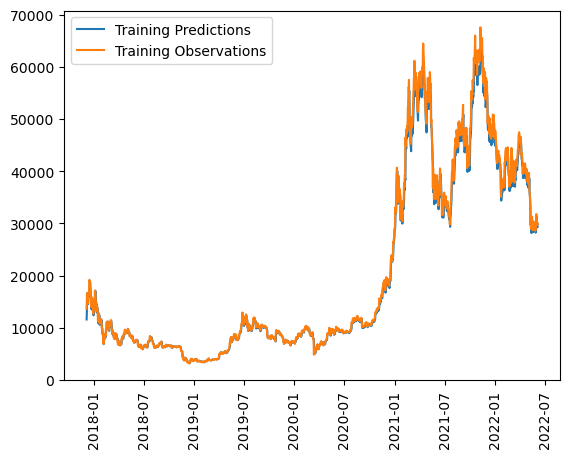

In [122]:
#Third model observations
train_predictions3 = model3.predict(X_train2).flatten()

plt.plot(dates_train2, np.exp(train_predictions3))
plt.plot(dates_train2, np.exp(y_train2))
plt.xticks(rotation=90)
plt.legend(['Training Predictions', 'Training Observations'])

In [123]:
score = model3.evaluate(X_val2, y_val2, verbose = 0) 

print('Val loss:', score[0]) 
print('Val MAE:', score[1])

Val loss: 0.0014803229132667184
Val MAE: 0.02847159095108509


8/8 [==============================] - 0s 14ms/step


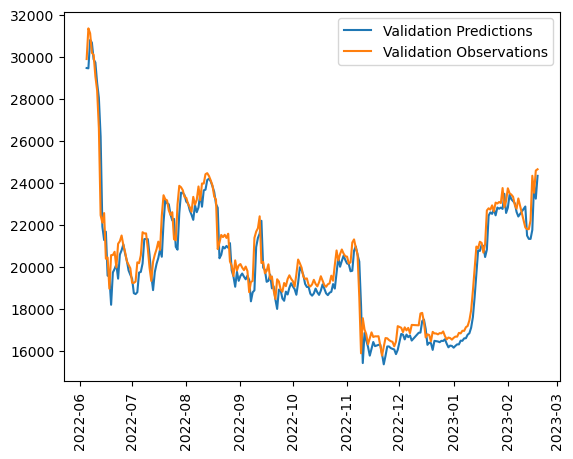

In [124]:
#Second model observations 
val_predictions3 = model3.predict(X_val2).flatten()

plt.plot(dates_val2, np.exp(val_predictions3))
plt.plot(dates_val2, np.exp(y_val2))
plt.xticks(rotation=90)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [125]:
# Third Model MAE score
score = model3.evaluate(X_test2, y_test2, verbose = 0) 

print('Test loss:', score[0]) 
print('Test MAE:', score[1])

Test loss: 0.0006779052200727165
Test MAE: 0.019540488719940186


7/7 [==============================] - 0s 12ms/step


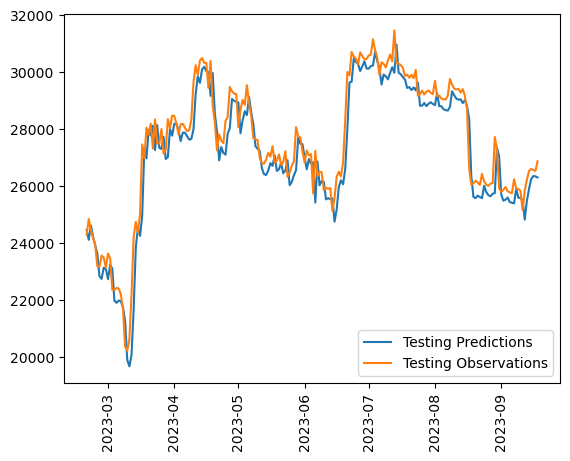

In [126]:
test_predictions3 = model3.predict(X_test2).flatten()

plt.plot(dates_test2, np.exp(test_predictions3))
plt.plot(dates_test2,np.exp(y_test2))
plt.xticks(rotation=90)
plt.legend(['Testing Predictions', 'Testing Observations'])

In [127]:
# R2 score for second model

print('R2 Score: ', r2_score(y_test2, test_predictions3))

R2 Score:  0.9091488566349412


## Future Prediction
- Attempting to look ahead x days in an attempt to predict upcoming trends

In [128]:
# Initialize an array to store predictions
predictions = []
predicted_dates = []
prediction_range = 7

#create list of numbers to add to date based on date range
date_range = list(range(1, prediction_range +1))

# Use the last n_steps data points from the training set to make predictions
current_batch = X_test2[-1]
current_reshape = current_batch.reshape((1, 30, 1))
initial_date = dates_test2[-1]

# Generate predictions for 7 days
for i in range(prediction_range): # Generate predictions for 7 days
    # Predict the next data point
    current_pred = model3.predict(current_reshape)[0,0]
    
    # Append the prediction to the list of predictions
    predictions.append(current_pred)
        

    # Update initial input for the next step
    updated_batch = np.insert(current_batch, -1, current_pred)
    
    #resize batch 
    current_batch = updated_batch[1:]
    
    #reshape batch
    current_reshape = current_batch.reshape((1, 30, 1))

#add dates to last date in dataset for future predictions   
for day in date_range:
    new_date = initial_date + dt.timedelta(days=day)
    predicted_dates.append(new_date
                          )
# 'predictions' contains 7-day forecast
print(predictions)

for date in predicted_dates:
    print(date)

1/1 [==============================] - 0s 25ms/step
[10.177529, 10.176587, 10.1758175, 10.175353, 10.175072, 10.175071, 10.175108]
2023-09-19
2023-09-20
2023-09-21
2023-09-22
2023-09-23
2023-09-24
2023-09-25


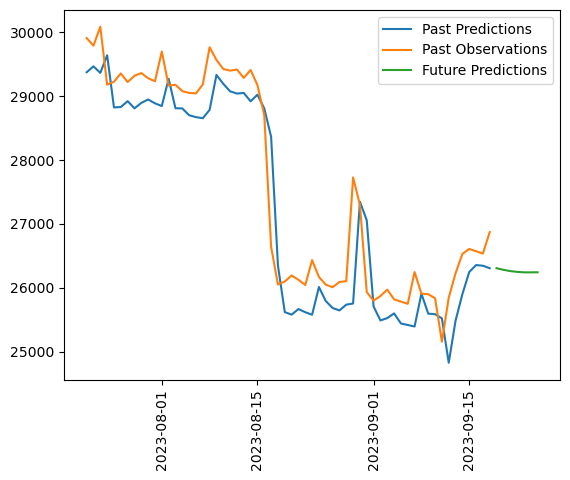

In [131]:
#Plot last 60 days of testing plus future prediction
plt.plot(dates_test2[-60:], np.exp(test_predictions3[-60:]))
plt.plot(dates_test2[-60:],np.exp(y_test2[-60:]))
plt.plot(predicted_dates, np.exp(predictions))
plt.xticks(rotation=90)
plt.legend(['Past Predictions', 'Past Observations','Future Predictions'])

In [132]:
# Export model1 to HDF5 file
model.save("H5_Files/btc_30_day_1.h5")

In [133]:
# Export model2 to HDF5 file
model2.save("H5_Files/btc_30_day_2.h5")

In [134]:
# Export model to HDF5 file
model3.save("H5_Files/btc_30_day_3.h5")

In [135]:
# build output into a df for graphing in js

df = pd.DataFrame({"Date": dates_test2[-90:], "observed":np.exp(y_test2[-90:]),\
                "model_1_predicted":np.exp(test_predictions[-90:]),\
                "model_2_predicted":np.exp(test_predictions2[-90:]),\
                "model_3_predicted":np.exp(test_predictions3[-90:])})
df.set_index('Date', inplace=True)


df


,observed,model_1_predicted,model_2_predicted,model_3_predicted
Date,,,,
2023-06-20,28315.0,29394.132812,27168.775391,26594.642578
2023-06-21,30009.0,30938.865234,28494.306641,27994.496094
2023-06-22,29889.0,32754.613281,30150.371094,29641.291016
2023-06-23,30716.0,32757.019531,30333.480469,29665.443359
2023-06-24,30548.0,33632.437500,31058.119141,30481.460938
...,...,...,...,...
2023-09-14,26529.0,28722.392578,26546.929688,25900.285156
2023-09-15,26607.0,29055.728516,26868.746094,26245.554688
2023-09-16,26571.0,29157.458984,26987.750000,26354.611328


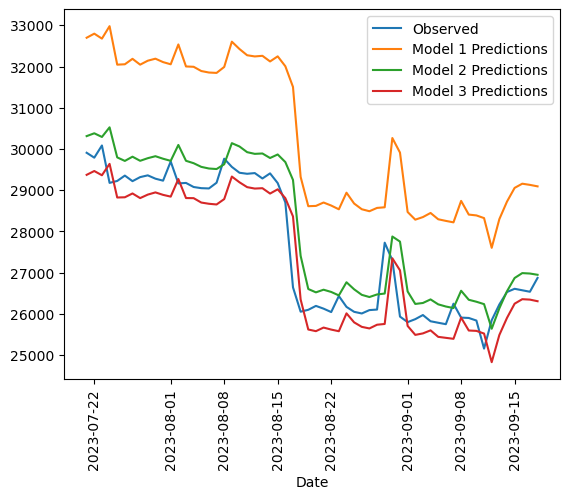

In [136]:
#Measuring each model's predictions against the test data
df[-60:].plot(use_index=True)
plt.xticks(rotation=90)

plt.legend(['Observed', 'Model 1 Predictions', 'Model 2 Predictions', \
            'Model 3 Predictions'])
plt.show()

In [137]:
#output prediction data to csv
df.to_csv('output/btc_predict_30.csv') 

In [138]:
#output original historical data to csv
data.to_csv('output/btc_lifetime_30.csv')

In [139]:
#Scores for each model

print('Model 1 R2 Score: ', r2_score(y_test1, test_predictions))
print('Model 2 R2 Score: ', r2_score(y_test2, test_predictions2))
print('Model 3 R2 Score: ', r2_score(y_test2, test_predictions3))

Model 1 R2 Score:  0.764257996294627
Model 2 R2 Score:  0.9003488710100125
Model 3 R2 Score:  0.9091488566349412
